In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,"../")

In [ ]:
from torch.utils.data import DataLoader
import torch

In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from core.model.model import MoCo_scene_and_view as MoCo
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features
from core.dataloader import sample_same_scene_negs
from vis_utils import *

In [ ]:
# kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
# kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

Initialised..... 10  files...


In [ ]:
PATH = "../tb_logs/two_obj_spatial_with_scene_and_view_loss_exp33/checkpoint_299.pth.tar"
state_dict = torch.load(PATH)['state_dict']
view_r = state_dict["queue_view"].shape[1]
scene_r = state_dict["queue_scene"].shape[1]

model = MoCo(mode="spatial", scene_r=scene_r, view_r=view_r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
from attrdict import AttrDict

args = AttrDict({
    'mode':"spatial",
    'hyp_N':2
})

In [ ]:
import time
t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())

        
print(pool_e_.num)
print(pool_g_.num)

40
684


[38, 22, 33, 30, 29, 9, 5, 10, 2, 26]


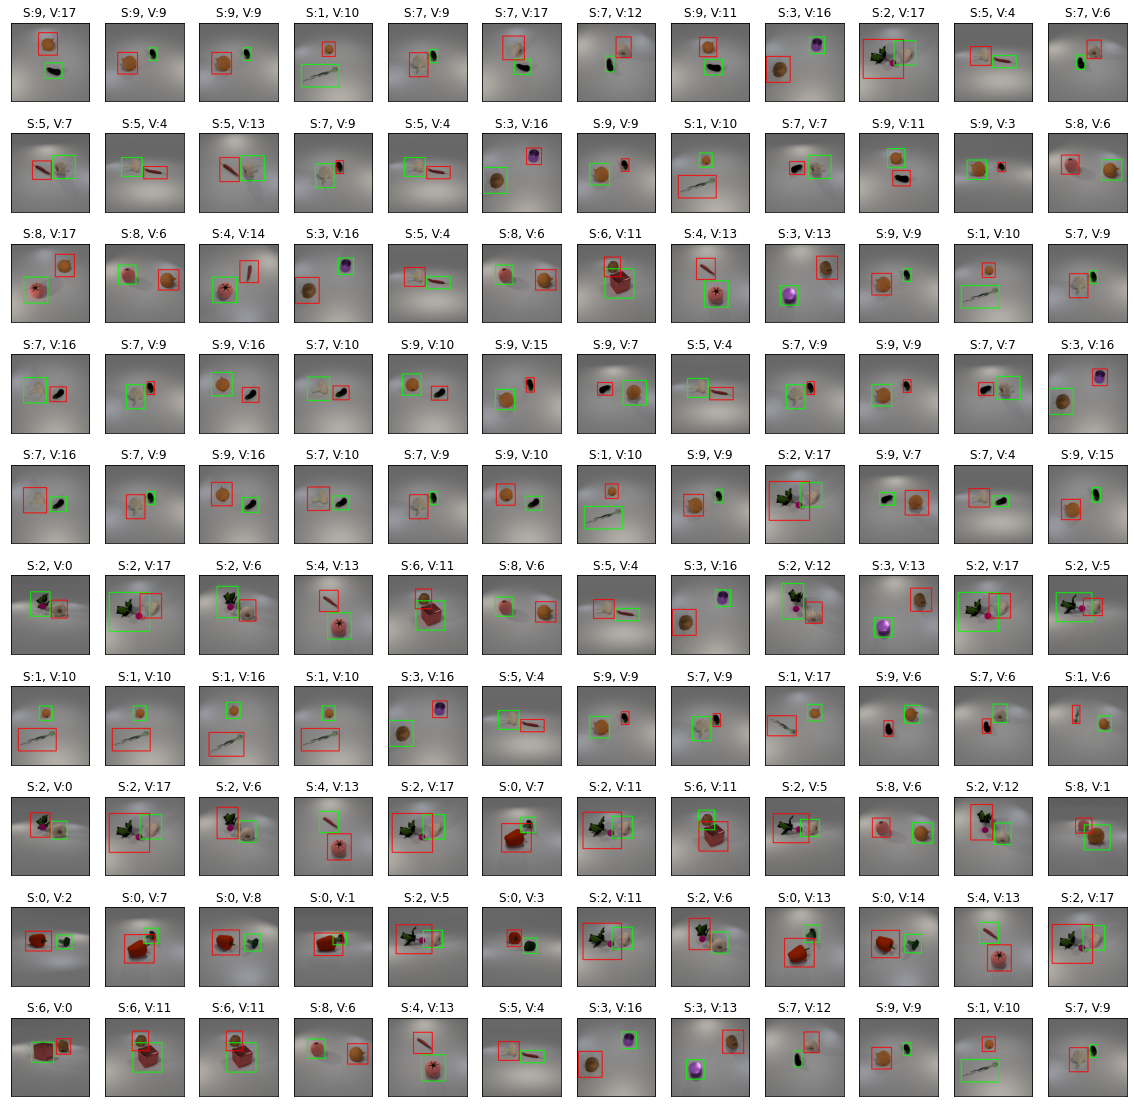

In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=10)

In [ ]:
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

train_iter = iter(query_train_loader)

In [ ]:
feed_q, feed_k, metadata = next(train_iter)
q_idx = metadata_["query_image_index"].item()
k_idx = metadata_["key_image_index"].item()
scene_num = metadata_["scene_number"].item()

../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [ ]:
q_idx, k_idx

(0, 4)

In [ ]:
model.eval()
with torch.no_grad():
    feat_q = model(feed_q, None, metadata, is_eval=True).cpu().numpy()
    feat_k = model(feed_k, None, metadata, is_eval=True).cpu().numpy()
    feat_k_t = model(feed_k, None, metadata, is_viewpoint_eval=True).cpu().numpy()

In [ ]:
from scipy.spatial import distance

In [ ]:
def get_distance(p1, p2):
    return [distance.cdist(p1[i].reshape(1,-1),p2[i].reshape(1,-1))[0][0] for i in range(4)]

In [ ]:
get_distance(feat_k,feat_k_t)

[1.1902450446285056, 1.2287146890972602, 1.242068533551345, 1.1076095841653437]

In [ ]:
get_distance(feat_q,feat_k_t)

[1.1953742150713558, 1.260359427515559, 1.1780445183158619, 1.2235225132576257]

In [ ]:
get_distance(feat_q,feat_k)

[0.4963174963020972, 0.9595255589442304, 1.048545793283947, 1.2696293395883202]

In [ ]:
query_indices_to_use=[]

for i in range(7):
    ret = np.random.randint(0,40,1)[0]
    if ret in query_indices_to_use or ret%4==0 or ret%4==3:
        continue
    else:
        query_indices_to_use.append(ret)

array([18])